# Import package and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
DATA_PATH = "../data/"
data = pd.read_csv(DATA_PATH+"2016_Building_Energy_Benchmarking.csv", sep=",", encoding="iso-8859-1")

# Phase 1

## Cleaning

In [3]:
pd.set_option('display.max_info_rows',50)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   OSEBuildingID                    int64  
 1   DataYear                         int64  
 2   BuildingType                     object 
 3   PrimaryPropertyType              object 
 4   PropertyName                     object 
 5   Address                          object 
 6   City                             object 
 7   State                            object 
 8   ZipCode                          float64
 9   TaxParcelIdentificationNumber    object 
 10  CouncilDistrictCode              int64  
 11  Neighborhood                     object 
 12  Latitude                         float64
 13  Longitude                        float64
 14  YearBuilt                        int64  
 15  NumberofBuildings                float64
 16  NumberofFloors                   int64  
 17  PropertyGFATot

In [4]:
data.isna().mean()[data.isna().mean() > 0.10]

SecondLargestPropertyUseType       0.502666
SecondLargestPropertyUseTypeGFA    0.502666
ThirdLargestPropertyUseType        0.823460
ThirdLargestPropertyUseTypeGFA     0.823460
YearsENERGYSTARCertified           0.964751
ENERGYSTARScore                    0.249704
Comments                           1.000000
Outlier                            0.990521
dtype: float64

In [5]:
label_1 = "TotalGHGEmissions"
label_2 = "SiteEnergyUse(kBtu)"

In [6]:
all_columns = list(data.columns)
categorical_columns = ["BuildingType", "PrimaryPropertyType","PropertyName","City","State","Address","City","State",
                       "ZipCode","CouncilDistrictCode","Neighborhood","ListOfAllPropertyUseTypes",
                       "LargestPropertyUseType","SecondLargestPropertyUseType","ThirdLargestPropertyUseType","ComplianceStatus"]
numerical_columns = [column for column in all_columns if column not in categorical_columns]

In [7]:
# Premier nettoyage du dataframe
def clean_data(df, to_drop):
    print("--------- shape before cleaning ---------")
    print(df.shape)
    df = df[df.ComplianceStatus == "Compliant"]
    df.Outlier.fillna('not_outlier', inplace=True)
    df.SecondLargestPropertyUseType.fillna('one_use', inplace=True)
    df.ThirdLargestPropertyUseType.fillna('one_use', inplace=True)
    df = df[df.NumberofBuildings != 0]
    df = df[df.NumberofFloors != 0]
    df = df[df['DefaultData'] == False]
    df.loc[df['SecondLargestPropertyUseType'] == 'one_use', 'SecondLargestPropertyUseTypeGFA'] = 0
    df.loc[df['ThirdLargestPropertyUseType'] == 'one_use', 'ThirdLargestPropertyUseTypeGFA'] = 0
    df['Nb_PropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].str.count(',') + 1
    df["Building_age"] = df["DataYear"] - df["YearBuilt"]
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna(df['PrimaryPropertyType'])
    df['LargestPropertyUseTypeGFA'] = df['LargestPropertyUseTypeGFA'].fillna(df['PropertyGFATotal'])
    df["%_LargestPropertyUseType"] = df["LargestPropertyUseTypeGFA"] / df["PropertyGFATotal"]    
    for col in to_drop:
        if col in df.columns:
            df = df.drop(columns=[col])
    print("--------- shape before cleaning ---------")
    print(df.shape)
    return df

# Mise à jour des listes des colonnes
def update_columns_list(list_1, dropped):
    new_list = [col for col in list_1 if col not in dropped]
    return new_list

In [8]:
# Vérifier la GFA
data["GFATotal"] = data["PropertyGFAParking"] + data["PropertyGFABuilding(s)"]
check_GPA = pd.Series(data["GFATotal"] == data["PropertyGFATotal"])
data.drop(columns=["GFATotal"], inplace=True)
check_GPA.value_counts()

True    3376
dtype: int64

In [9]:
data = data[~data.BuildingType.isin(["Multifamily LR (1-4)","Multifamily MR (5-9)","Multifamily HR (10+)"])]
data["%_GFAParking"] = data["PropertyGFAParking"] / data["PropertyGFATotal"]
data["%_GFABuilding"] = data["PropertyGFABuilding(s)"] / data["PropertyGFATotal"]


In [10]:
columns_to_drop = ["DataYear","PropertyName","Address","City","State",
                "Latitude","Longitude","YearBuilt","TaxParcelIdentificationNumber",
                "YearsENERGYSTARCertified","Comments","DefaultData","ComplianceStatus",
                "SiteEnergyUseWN(kBtu)","PropertyGFAParking","PropertyGFABuilding(s)","ListOfAllPropertyUseTypes"]

In [11]:
data = clean_data(data, columns_to_drop)
categorical_columns = update_columns_list(categorical_columns,columns_to_drop)

--------- shape before cleaning ---------
(1668, 48)
--------- shape before cleaning ---------
(1481, 34)


/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [12]:
data.BuildingType.value_counts()

NonResidential        1375
Nonresidential COS      73
Campus                  22
SPS-District K-12       10
Nonresidential WA        1
Name: BuildingType, dtype: int64

In [13]:
pd.set_option('display.max_columns',50)
data.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,%_GFAParking,%_GFABuilding,Nb_PropertyUseTypes,Building_age,%_LargestPropertyUseType
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,12,88434,Hotel,88434.0,one_use,0.0,one_use,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,not_outlier,249.98,2.83,0.000000,1.000000,1,89,1.000000
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,11,103566,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,not_outlier,295.86,2.86,0.145453,0.854547,3,20,0.809918
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,41,956110,Hotel,756493.0,one_use,0.0,one_use,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,not_outlier,2089.28,2.19,0.205748,0.794252,1,47,0.791220
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,10,61320,Hotel,61320.0,one_use,0.0,one_use,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,not_outlier,286.43,4.67,0.000000,1.000000,1,90,1.000000
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,1.0,18,175580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,not_outlier,505.01,2.88,0.353115,0.646885,3,36,0.703070


In [14]:
data.ENERGYSTARScore = data.ENERGYSTARScore.fillna('no_score')
data = data[data["ENERGYSTARScore"] != 'no_score']

In [15]:
features = ['BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'Neighborhood',  'Building_age','NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA',  '%_LargestPropertyUseType',
       'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)',
       'TotalGHGEmissions',
       '%_GFAParking', '%_GFABuilding','Nb_PropertyUseTypes']

In [16]:
categorical_columns = update_columns_list(categorical_columns,columns_to_drop)
numerical_columns = update_columns_list(numerical_columns,columns_to_drop)

In [17]:
df = data[features]
cat_features = [col for col in features if col in categorical_columns]
num_features = [col for col in features if col in categorical_columns]

## Exploration label

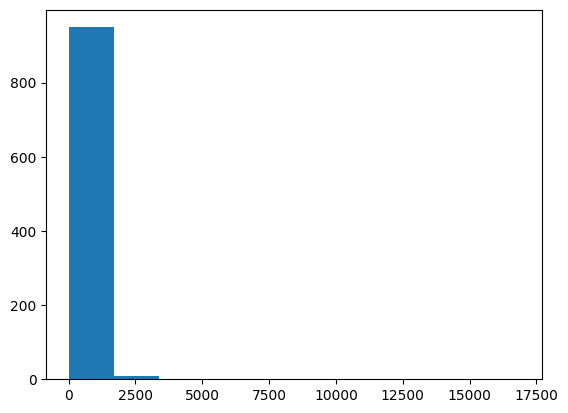

In [18]:
plt.hist(df["TotalGHGEmissions"]);

In [19]:
df["TotalGHGEmissions"].describe()

count      964.000000
mean       193.268672
std        873.974092
min         -0.800000
25%         20.165000
50%         49.215000
75%        140.090000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

In [20]:
df["TotalGHGEmissions"].quantile([0, .5, 0.98])

0.00      -0.8000
0.50      49.2150
0.98    1008.6684
Name: TotalGHGEmissions, dtype: float64

In [21]:
df = df[df["TotalGHGEmissions"] <= df["TotalGHGEmissions"].quantile([0.98])[0.98]]
df = df[df["TotalGHGEmissions"] > 0]

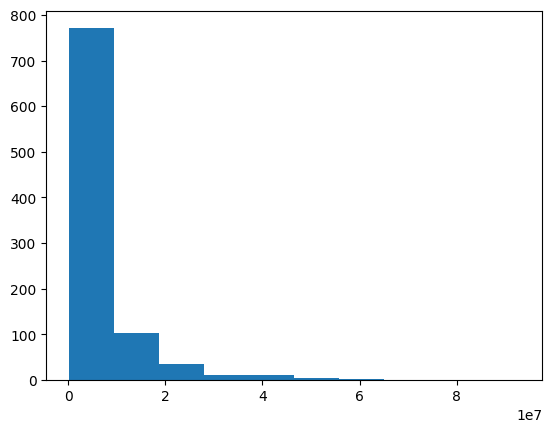

In [22]:
plt.hist(df[label_2]);

In [23]:
df[label_1].describe()

count    942.000000
mean     106.159830
std      145.085844
min        0.810000
25%       19.937500
50%       47.975000
75%      130.575000
max      940.470000
Name: TotalGHGEmissions, dtype: float64

In [24]:
df[label_2].describe()

count    9.420000e+02
mean     6.206883e+06
std      9.461551e+06
min      7.971180e+04
25%      1.236609e+06
50%      2.687720e+06
75%      7.033444e+06
max      9.293764e+07
Name: SiteEnergyUse(kBtu), dtype: float64

## Categorical features

In [25]:
df.BuildingType.nunique(), df.PrimaryPropertyType.nunique(), df.ZipCode.nunique(), df.Neighborhood.nunique(), df.LargestPropertyUseType.nunique()

(4, 16, 38, 18, 19)

In [26]:
def pipe_ohe(df):
    
    #### encoder la colonne LargestPropertyUseType ###
    # Ajouter les colonnes encodées au dataframe d'origine
    # Supprimer la colonne originale
    onehot_encoded = pd.get_dummies(df['LargestPropertyUseType'], prefix='LargestPropertyUseType')
    df = pd.concat([df, onehot_encoded], axis=1)
    df.drop('LargestPropertyUseType', axis=1, inplace=True)
    
    #### encoder la colonne BuildingType ###
    # Ajouter les colonnes encodées au dataframe d'origine
    # Supprimer la colonne originale
    onehot_encoded_BuildingType = pd.get_dummies(df['BuildingType'], prefix='BuildingType')
    df = pd.concat([df, onehot_encoded_BuildingType], axis=1)
    df.drop('BuildingType', axis=1, inplace=True)
    
    ### Remplacer les valeurs 1/0 de LargestPropertyUseType_ par leur % de la surface totale
    # Liste des colonnes à remplacer
    # Boucle pour remplacer les valeurs dans chaque colonne
    cols_to_replace = list(df.filter(like="LargestPropertyUseType_").columns)
    for col in cols_to_replace:
        df[col] = df.apply(lambda row: row["%_LargestPropertyUseType"] if row[col] == 1 else 0, axis=1)    
    df.drop(columns=["%_LargestPropertyUseType"], inplace=True)
    
    return df
    

In [27]:
X = pipe_ohe(df)
y1 = df[[label_1]]
y2 = df[[label_2]]

X_enrg_train, X_enrg_test, y_enrg_train, y_enrg_test = train_test_split(X,y1,test_size=0.15, random_state=42, stratify=df["BuildingType"])
print(X_enrg_train.shape, X_enrg_test.shape)

# séparer la donnée pour avoir les 
X_ghe_train, X_ghe_test, y_ghe_train, y_ghe_test = train_test_split(X,y2,test_size=0.15, random_state=42, stratify=df["BuildingType"])
print(X_ghe_train.shape, X_ghe_test.shape)

(800, 40) (142, 40)
(800, 40) (142, 40)


In [28]:
def pipe(df, means_zipcode=None, 
                means_neighborhood=None,
                means_ppropertype=None, 
                col_for_mean="PropertyGFATotal", 
                scaler=None,
                label_1=label_1,
                label_2=label_2):
    #### encoder la colonne ZipCode ###
    # encoding ZipCode with mean encoding and TotalGHGEmissions #
    # Calculer la moyenne de la colonne cible (label2) pour chaque code postal
    # Encoder la colonne code postal en fonction de la moyenne de la colonne cible
    # Supprimer la colonne originale
    mean_encoding_nan = df[col_for_mean].mean()
    if means_zipcode is None:
        means_zipcode = df.groupby('ZipCode')[col_for_mean].mean()
    df['Code_postal_encoded'] = df['ZipCode'].map(means_zipcode)
    df['Code_postal_encoded'].fillna(mean_encoding_nan, inplace=True)
    
    ### encoder la colonne Neighborhood ###
    # Calculer la moyenne de la colonne cible (label2) pour chaque quartier
    # Encoder la colonne quartier en fonction de la moyenne de la colonne cible
    # Supprimer la colonne originale
    if means_neighborhood is None:
        means_neighborhood = df.groupby('Neighborhood')[col_for_mean].mean()
    df['neighborhood_encoded'] = df['Neighborhood'].map(means_neighborhood)
    df.drop(columns=['Neighborhood'],inplace=True)
    df['neighborhood_encoded'].fillna(mean_encoding_nan, inplace=True)
    
    
    ### encoder la colonne PrimaryPropertyType with mean encoding  ###
    # Calculer la moyenne de la colonne cible (label2) pour chaque PrimaryPropertyType
    # Encoder la colonne PrimaryPropertyType en fonction de la moyenne de la colonne cible
    # Supprimer la colonne catégorielle
    if means_ppropertype is None:
        means_ppropertype = df.groupby('PrimaryPropertyType')[col_for_mean].mean()
    df['PrimaryPropertyType_encoded'] = df['PrimaryPropertyType'].map(means_ppropertype)
    df.drop(columns=['PrimaryPropertyType'],inplace=True)
    df['PrimaryPropertyType_encoded'].fillna(mean_encoding_nan, inplace=True)
    
    #supprimer les labels du jeu de données
    df = df.drop(columns=[label_1,label_2])
    df.drop(columns=['SourceEUI(kBtu/sf)', 'SteamUse(kBtu)','Electricity(kBtu)', 'NaturalGas(kBtu)'], inplace=True)
    
    #scaler
    if scaler is None:
        scaler=StandardScaler()
        df_scaled = scaler.fit_transform(df)
        print("check scaler standard scaler")
    else:
        df_scaled = scaler.transform(df)
        print("check scaler the train scaler")
    
    return df_scaled, means_zipcode, means_neighborhood, means_ppropertype, df.columns, scaler
    

In [29]:
X_enrg_train, means_zipcode_enrg, means_neighborhood_enrg, means_ppropertype_enrg, columns_enrg, nrg_train_scaler = pipe(X_enrg_train,col_for_mean=label_1)
X_enrg_test, means_zipcode_enrg, means_neighborhood_enrg, means_ppropertype_enrg, a, scaler = pipe(X_enrg_test,
                                                                        means_zipcode=means_zipcode_enrg,
                                                                        means_neighborhood=means_neighborhood_enrg,
                                                                        means_ppropertype=means_ppropertype_enrg,
                                                                        col_for_mean=label_1,
                                                                        scaler=nrg_train_scaler)

check scaler standard scaler
check scaler the train scaler


In [30]:
X_ghe_train, means_zipcode_ghe, means_neighborhood_ghe, means_ppropertype_ghe, columns_ghe, ghe_train_scaler = pipe(X_ghe_train,col_for_mean=label_2)
X_ghe_test, means_zipcode_ghe, means_neighborhood_ghe, means_ppropertype_ghe, b, scaler = pipe(X_ghe_test, 
                                                                        means_zipcode=means_zipcode_ghe,
                                                                        means_neighborhood=means_neighborhood_ghe,
                                                                        means_ppropertype=means_ppropertype_ghe,
                                                                        col_for_mean=label_2,
                                                                        scaler=ghe_train_scaler)

check scaler standard scaler
check scaler the train scaler


In [31]:
print(X_enrg_train.shape, X_enrg_test.shape), 
print(X_ghe_train.shape, X_ghe_test.shape)

(800, 35) (142, 35)
(800, 35) (142, 35)


## Modèles

###  Results functions

In [32]:
def results_printed(model):
    # Best score                     
    print(f"Best score : {model.best_score_}")
    
    # Best Params
    print(f"Best params :\n {model.best_params_}")

In [33]:
metrics_df = pd.DataFrame(columns=["label","modèle","r2","mae","rmse","mean_fit_time","best_params"])

def add_metrics_table(label,y_pred,y_test,df,model):    
    r2 = round(r2_score(y_test, y_pred), 8)
    mae = round(mean_absolute_error(y_test, y_pred), 5)
    rmse = round(mean_squared_error(y_test, y_pred), 5)
    df = df.append({
    "label": label,
    "modèle": model.best_estimator_,
    "r2": '{:.4f}'.format(r2),
    "mae": '{:.4f}'.format(mae),
    "rmse": '{:.4f}'.format(rmse),
    "mean_fit_time": model.cv_results_['mean_fit_time'].mean(),
    "best_params": model.best_params_
    }, ignore_index=True)
    return df

scoring = ["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"]

def evaluate_prediction(label, X_test, y_test, metrics_df, model):
    y_pred = model.predict(X_test)

    metrics_df = add_metrics_table(label,y_pred,y_test,metrics_df,model)

    # Créer le scatter plot
    plt.scatter(y_pred, y_test)

    # Ajouter une ligne diagonale pour représenter la ligne de prédiction parfaite
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

    # Ajouter des labels pour les axes et le titre du plot
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.title('Comparaison des prédictions et des valeurs réelles')

    # Afficher le plot
    plt.show()
    display(metrics_df)
    return metrics_df

In [34]:
def show_fetures_coef(model, columns):
    coef = model.best_estimator_.coef_
    if coef.ndim == 2 and coef.shape[0] == 1:
        coef = coef[0]
    features_coef = pd.DataFrame(coef.reshape(1,-1), columns=list(columns))
    columns = list(reversed(features_coef.columns))
    coef = list(reversed(coef))
    
    
    plt.figure(figsize=(14,8))
    # Créer un graphique à barres horizontales
    plt.barh(columns, coef)

    # Récupérer les étiquettes de l'axe des abscisses
    labels = plt.gca().get_yticklabels()

    # Parcourir les étiquettes et appliquer un style différent aux étiquettes non nulles
    for label, value in zip(labels, coef):
        if value != -0:
            label.set_color('red')  # Appliquer une couleur rouge aux étiquettes non nulles
        else:
            label.set_color('black')  # Appliquer une couleur noire aux étiquettes nulles

    plt.show()

## Label 1 : energy

### Dummy regression

In [35]:
dummy_regr = DummyRegressor()
parameters = {"strategy" : ("mean","median","quantile"),
            "quantile" : [0.25,0.5,0.75]}
grid_dummy_nrg = GridSearchCV(dummy_regr, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit = "r2")
grid_dummy_nrg.fit(X_enrg_train, y_enrg_train)

GridSearchCV(cv=5, estimator=DummyRegressor(), n_jobs=-1,
             param_grid={'quantile': [0.25, 0.5, 0.75],
                         'strategy': ('mean', 'median', 'quantile')},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

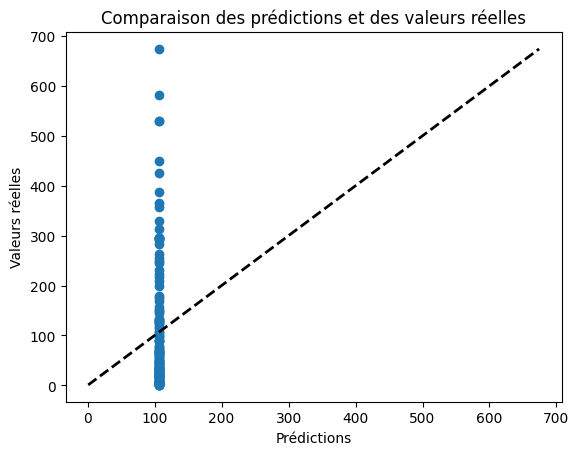

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"


In [36]:
metrics_df = evaluate_prediction(label_1,X_enrg_test, y_enrg_test, metrics_df, grid_dummy_nrg)

### Linear Regression

In [37]:
reg = LinearRegression(random_state=42)
parameters = {'fit_intercept': [True, False]}
grid_reglin_nrg = GridSearchCV(reg,
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_reglin_nrg.fit(X_enrg_train, y_enrg_train)

GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False]}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

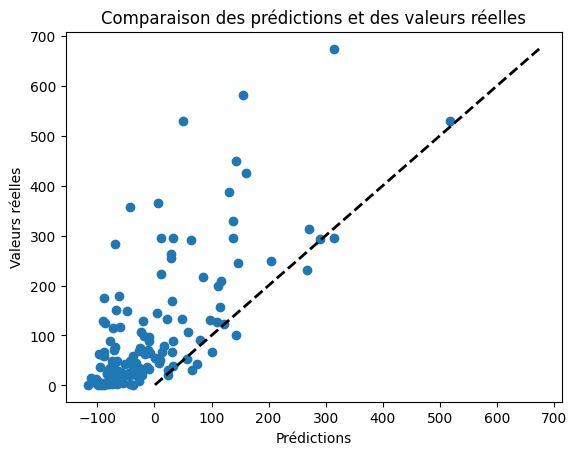

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}


In [38]:
metrics_df = evaluate_prediction(label_1,X_enrg_test, y_enrg_test, metrics_df, grid_reglin_nrg)

### Lasso Regression

In [39]:
lasso = Lasso(random_state=42)
alpha_space = np.logspace(-4, 2, 15)   # Checking for alpha from .0001 to 1 and finding the best value for alpha
parameters = {"alpha" : alpha_space}
grid_lasso_nrg = GridSearchCV(lasso, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_lasso_nrg.fit(X_enrg_train, y_enrg_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 2.68269580e-04, 7.19685673e-04, 1.93069773e-03,
       5.17947468e-03, 1.38949549e-02, 3.72759372e-02, 1.00000000e-01,
       2.68269580e-01, 7.19685673e-01, 1.93069773e+00, 5.17947468e+00,
       1.38949549e+01, 3.72759372e+01, 1.00000000e+02])},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

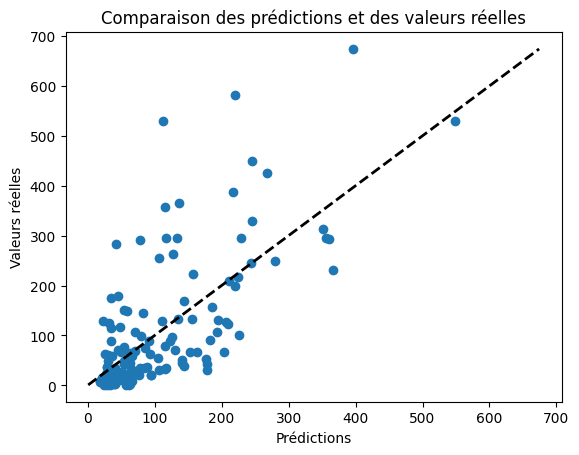

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}


In [40]:
metrics_df = evaluate_prediction(label_1,X_enrg_test, y_enrg_test, metrics_df, grid_lasso_nrg)

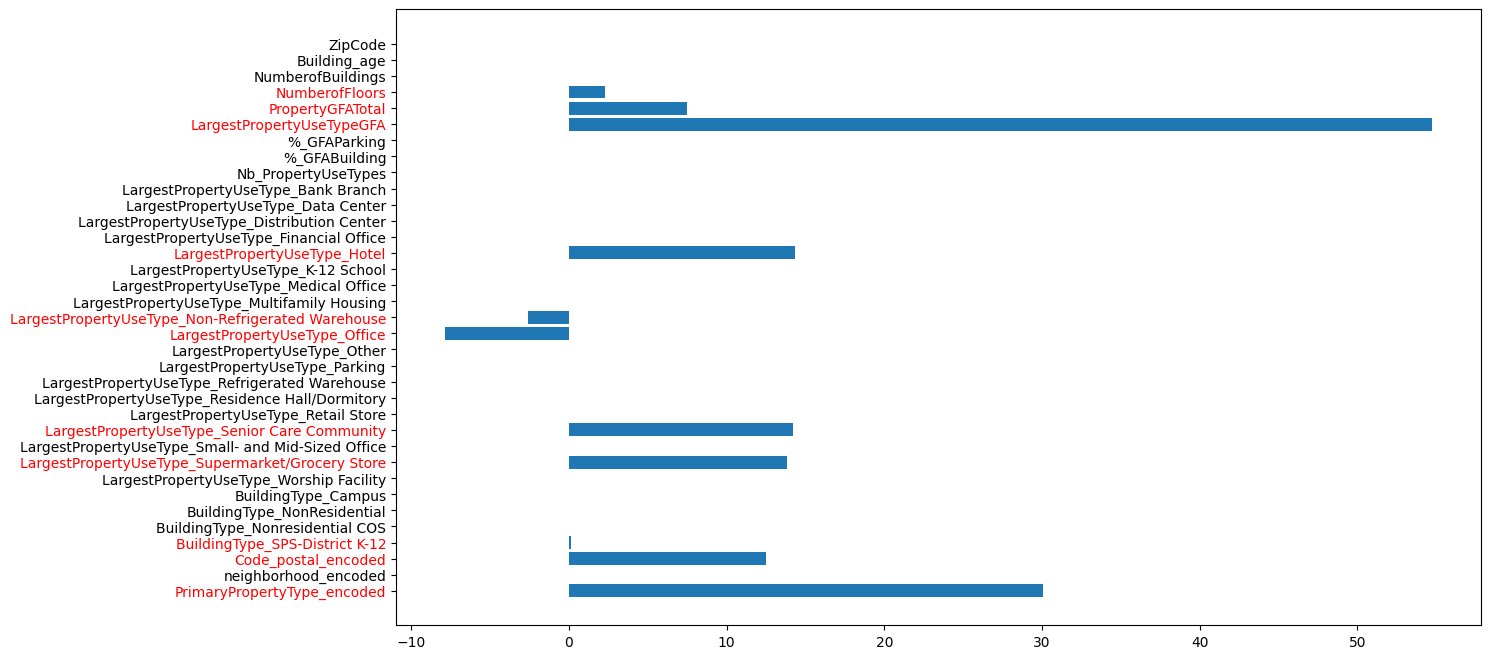

In [41]:
show_fetures_coef(grid_lasso_nrg, columns_enrg)

### Ridge regression

In [42]:
ridge = Ridge(random_state=42)
alpha_space = np.logspace(-5, 3, 15)   # Checking for alpha from .0001 to 1 and finding the best value for alpha
parameters = {"alpha" : alpha_space}
grid_ridge_nrg = GridSearchCV(ridge, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_ridge_nrg.fit(X_enrg_train, y_enrg_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-05, 3.72759372e-05, 1.38949549e-04, 5.17947468e-04,
       1.93069773e-03, 7.19685673e-03, 2.68269580e-02, 1.00000000e-01,
       3.72759372e-01, 1.38949549e+00, 5.17947468e+00, 1.93069773e+01,
       7.19685673e+01, 2.68269580e+02, 1.00000000e+03])},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

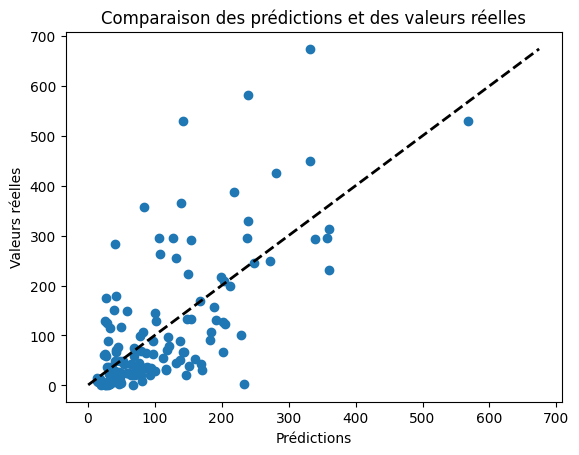

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}


In [43]:
metrics_df = evaluate_prediction(label_1,X_enrg_test, y_enrg_test, metrics_df, grid_ridge_nrg)

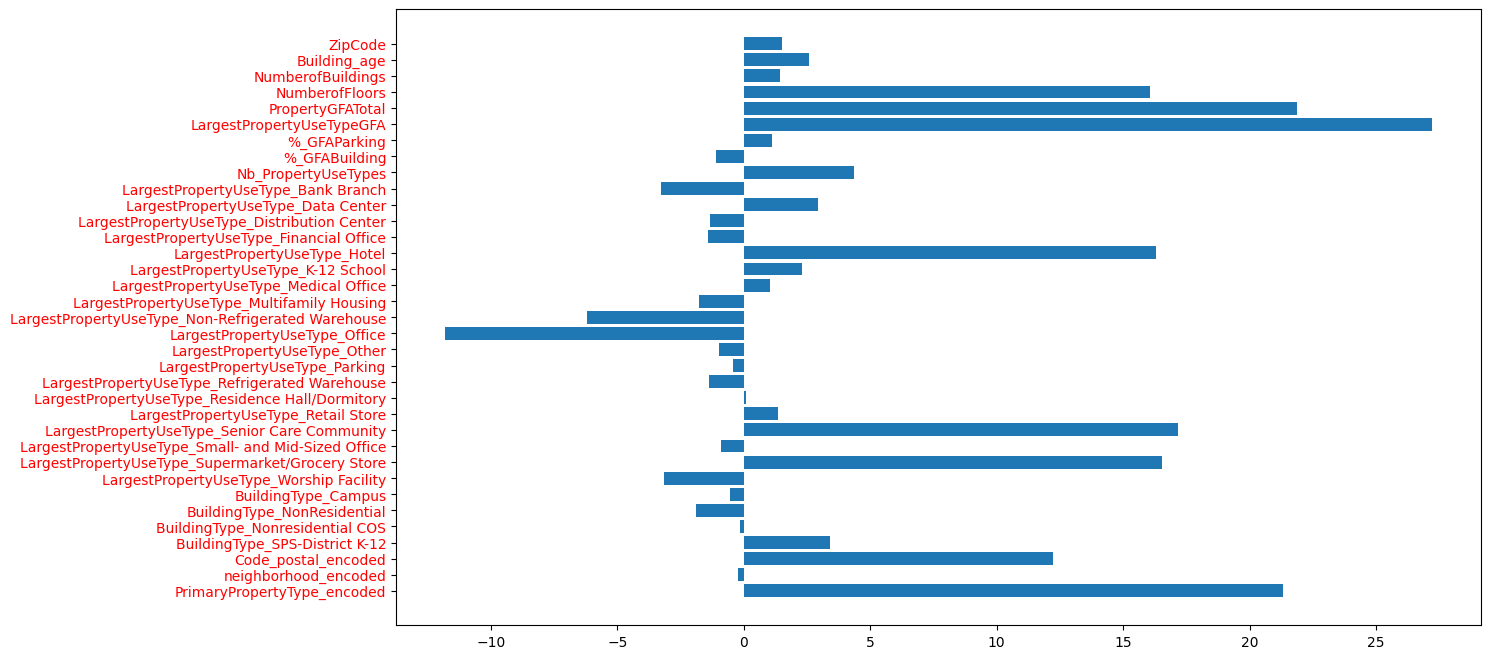

In [44]:
show_fetures_coef(grid_ridge_nrg, columns_enrg)

### Elastic Net

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.455e+06, tolerance: 1.317e+03
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.706e+06, tolerance: 1.584e+03
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

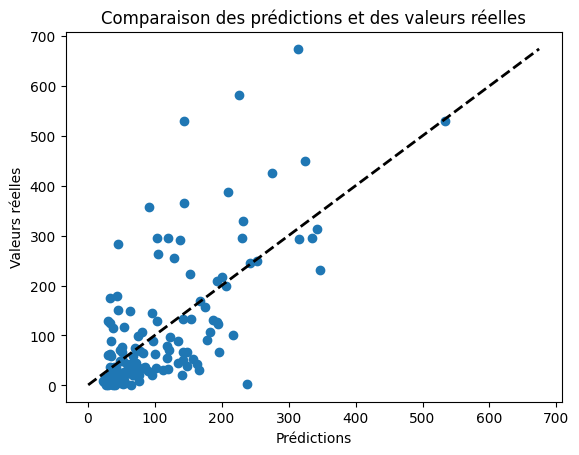

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.148406,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."


In [45]:
elnet = ElasticNet(max_iter=20000,random_state=42)
alpha_space = np.logspace(-5, 3, 15)   # Checking for alpha from .0001 to 1 and finding the best value for alpha
l1_space = np.logspace(-3, 0, 15)
parameters = {"alpha" : alpha_space,
            "l1_ratio" : l1_space}
grid_elnet_nrg = GridSearchCV(elnet, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_elnet_nrg.fit(X_enrg_train, y_enrg_train)

metrics_df = evaluate_prediction(label_1,X_enrg_test, y_enrg_test, metrics_df, grid_elnet_nrg)

### Decision tree Regressor

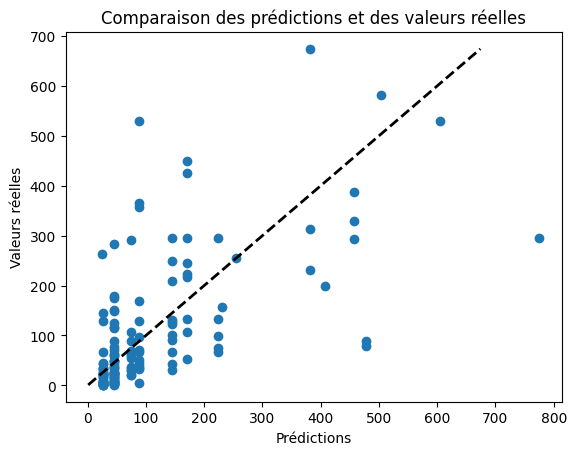

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.148406,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,DecisionTreeRegressor(max_depth=5),0.2602,68.8081,12546.9954,0.007581,"{'max_depth': 5, 'min_samples_leaf': 1}"


In [46]:
dectree = DecisionTreeRegressor(random_state=42)
parameters = {'min_samples_leaf': [1, 2, 3],
            'max_depth': range(5,10)}

grid_dectree_nrg = GridSearchCV(dectree, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_dectree_nrg.fit(X_enrg_train, y_enrg_train)

metrics_df = evaluate_prediction(label_1,X_enrg_test, y_enrg_test, metrics_df, grid_dectree_nrg)

### RandomForestRegressor

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/cyrielle/.pyenv

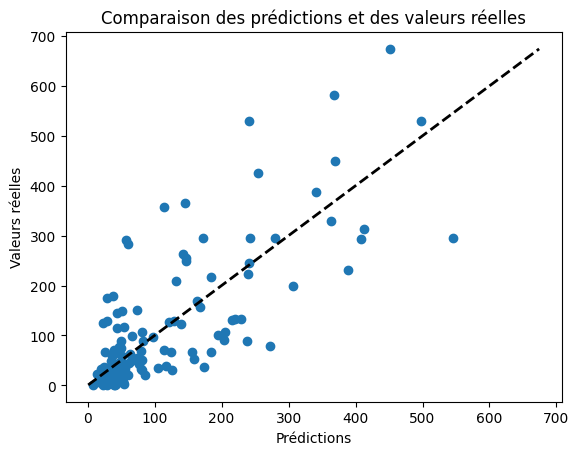

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.148406,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,DecisionTreeRegressor(max_depth=5),0.2602,68.8081,12546.9954,0.007581,"{'max_depth': 5, 'min_samples_leaf': 1}"
6,TotalGHGEmissions,(DecisionTreeRegressor(criterion='absolute_err...,0.6017,54.9597,6755.7271,0.994573,"{'criterion': 'absolute_error', 'max_features'..."


In [47]:
randomforest = RandomForestRegressor(random_state=42)
parameters = {'min_samples_leaf': [1, 2, 3],
            'criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
            'max_features': [0.3,0.5,0.75,1,"sqrt","log2"]}

grid_randomforest_nrg = GridSearchCV(randomforest, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_randomforest_nrg.fit(X_enrg_train, y_enrg_train)

metrics_df = evaluate_prediction(label_1,X_enrg_test, y_enrg_test, metrics_df, grid_randomforest_nrg)

### XGboost

[21:22:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:22:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:22:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:22:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:22:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:22:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/

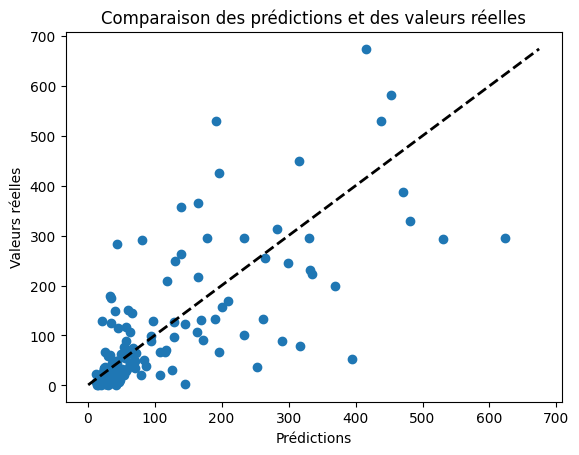

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.148406,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,DecisionTreeRegressor(max_depth=5),0.2602,68.8081,12546.9954,0.007581,"{'max_depth': 5, 'min_samples_leaf': 1}"
6,TotalGHGEmissions,(DecisionTreeRegressor(criterion='absolute_err...,0.6017,54.9597,6755.7271,0.994573,"{'criterion': 'absolute_error', 'max_features'..."
7,TotalGHGEmissions,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.4637,60.8042,9095.3301,6.415867,"{'eta': 0.01, 'max_features': 0.3, 'n_estimato..."


In [48]:
xgboost = xgboost.XGBRegressor(random_state=42)
parameters = {'n_estimators': range(1000,1500,100),
            'eta': [0.01,0.001,0.03,0.1,0.3],
            'max_features': [0.3,0.5,0.75,1,"sqrt","log2"]}

grid_xgboost_nrg = GridSearchCV(xgboost, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_xgboost_nrg.fit(X_enrg_train, y_enrg_train)

metrics_df = evaluate_prediction(label_1,X_enrg_test, y_enrg_test, metrics_df, grid_xgboost_nrg)

### LightBoost

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/v

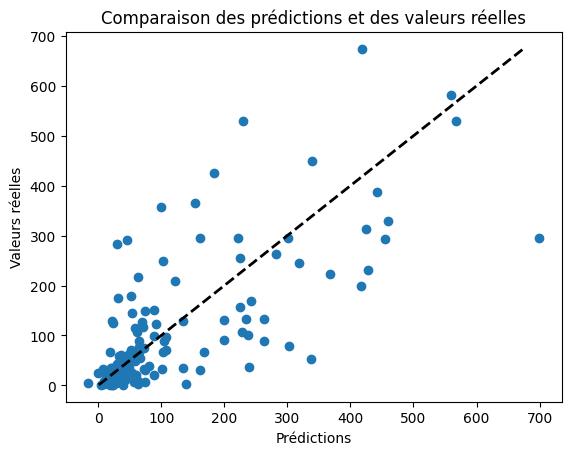

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.148406,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,DecisionTreeRegressor(max_depth=5),0.2602,68.8081,12546.9954,0.007581,"{'max_depth': 5, 'min_samples_leaf': 1}"
6,TotalGHGEmissions,(DecisionTreeRegressor(criterion='absolute_err...,0.6017,54.9597,6755.7271,0.994573,"{'criterion': 'absolute_error', 'max_features'..."
7,TotalGHGEmissions,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.4637,60.8042,9095.3301,6.415867,"{'eta': 0.01, 'max_features': 0.3, 'n_estimato..."
8,TotalGHGEmissions,"LGBMRegressor(learning_rate=0.01, n_estimators...",0.4331,62.5931,9615.3190,2.012598,"{'learning_rate': 0.01, 'n_estimators': 1000}"


In [49]:
lightboost = LGBMRegressor(random_state=42)
parameters = {'n_estimators': range(1000,1500,100),
            'learning_rate': [0.01,0.001,0.03,0.1,0.3]}

grid_lightboost_nrg = GridSearchCV(lightboost, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_lightboost_nrg.fit(X_enrg_train, y_enrg_train)

metrics_df = evaluate_prediction(label_1,X_enrg_test, y_enrg_test, metrics_df, grid_lightboost_nrg)

## Label 2 - GHE

### Dummy Regression

In [50]:
dummy_regr = DummyRegressor()
parameters = {"strategy" : ("mean","median")}
grid_dummy_ghe = GridSearchCV(dummy_regr, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_dummy_ghe.fit(X_ghe_train, y_ghe_train)

GridSearchCV(cv=5, estimator=DummyRegressor(), n_jobs=-1,
             param_grid={'strategy': ('mean', 'median')}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

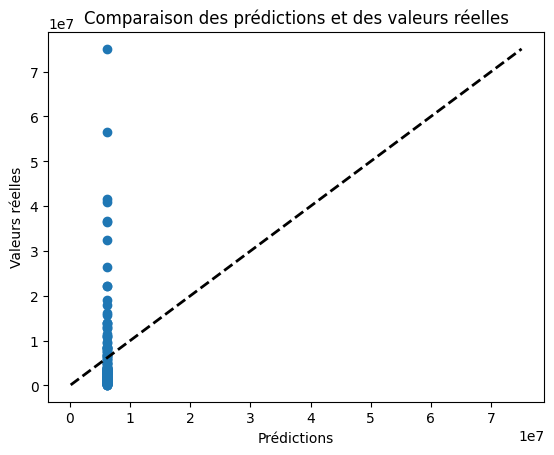

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.148406,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,DecisionTreeRegressor(max_depth=5),0.2602,68.8081,12546.9954,0.007581,"{'max_depth': 5, 'min_samples_leaf': 1}"
6,TotalGHGEmissions,(DecisionTreeRegressor(criterion='absolute_err...,0.6017,54.9597,6755.7271,0.994573,"{'criterion': 'absolute_error', 'max_features'..."
7,TotalGHGEmissions,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.4637,60.8042,9095.3301,6.415867,"{'eta': 0.01, 'max_features': 0.3, 'n_estimato..."
8,TotalGHGEmissions,"LGBMRegressor(learning_rate=0.01, n_estimators...",0.4331,62.5931,9615.3190,2.012598,"{'learning_rate': 0.01, 'n_estimators': 1000}"
9,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004550,{'strategy': 'mean'}


In [51]:
metrics_df = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df, grid_dummy_ghe)

### Linear Regression

In [52]:
parameters = {'fit_intercept': [True, False]}
grid_reglin_ghe = GridSearchCV(reg,
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_reglin_ghe.fit(X_ghe_train, y_ghe_train)

GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False]}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

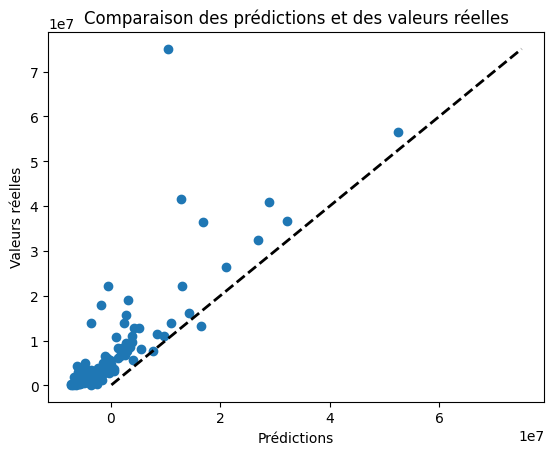

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.148406,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,DecisionTreeRegressor(max_depth=5),0.2602,68.8081,12546.9954,0.007581,"{'max_depth': 5, 'min_samples_leaf': 1}"
6,TotalGHGEmissions,(DecisionTreeRegressor(criterion='absolute_err...,0.6017,54.9597,6755.7271,0.994573,"{'criterion': 'absolute_error', 'max_features'..."
7,TotalGHGEmissions,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.4637,60.8042,9095.3301,6.415867,"{'eta': 0.01, 'max_features': 0.3, 'n_estimato..."
8,TotalGHGEmissions,"LGBMRegressor(learning_rate=0.01, n_estimators...",0.4331,62.5931,9615.3190,2.012598,"{'learning_rate': 0.01, 'n_estimators': 1000}"
9,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004550,{'strategy': 'mean'}


In [53]:
metrics_df = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df, grid_reglin_ghe)

### Lasso Regression

In [54]:
lasso = Lasso(max_iter=10000, tol=0.0001,random_state=42)
alpha_space = np.logspace(-5, 5, 15)   # Checking for alpha from .0001 to 10000 and finding the best value for alpha
parameters = {"alpha" : alpha_space}
grid_lasso_ghe = GridSearchCV(lasso, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_lasso_ghe.fit(X_ghe_train, y_ghe_train)

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.755e+14, tolerance: 5.490e+12
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.275e+14, tolerance: 6.029e+12
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-05, 5.17947468e-05, 2.68269580e-04, 1.38949549e-03,
       7.19685673e-03, 3.72759372e-02, 1.93069773e-01, 1.00000000e+00,
       5.17947468e+00, 2.68269580e+01, 1.38949549e+02, 7.19685673e+02,
       3.72759372e+03, 1.93069773e+04, 1.00000000e+05])},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

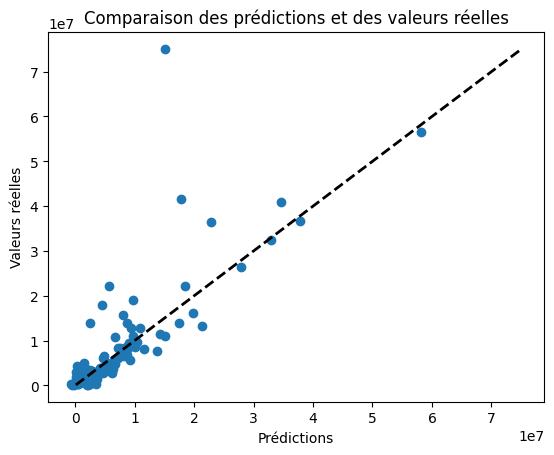

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.148406,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,DecisionTreeRegressor(max_depth=5),0.2602,68.8081,12546.9954,0.007581,"{'max_depth': 5, 'min_samples_leaf': 1}"
6,TotalGHGEmissions,(DecisionTreeRegressor(criterion='absolute_err...,0.6017,54.9597,6755.7271,0.994573,"{'criterion': 'absolute_error', 'max_features'..."
7,TotalGHGEmissions,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.4637,60.8042,9095.3301,6.415867,"{'eta': 0.01, 'max_features': 0.3, 'n_estimato..."
8,TotalGHGEmissions,"LGBMRegressor(learning_rate=0.01, n_estimators...",0.4331,62.5931,9615.3190,2.012598,"{'learning_rate': 0.01, 'n_estimators': 1000}"
9,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004550,{'strategy': 'mean'}


In [55]:
metrics_df = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df, grid_lasso_ghe)

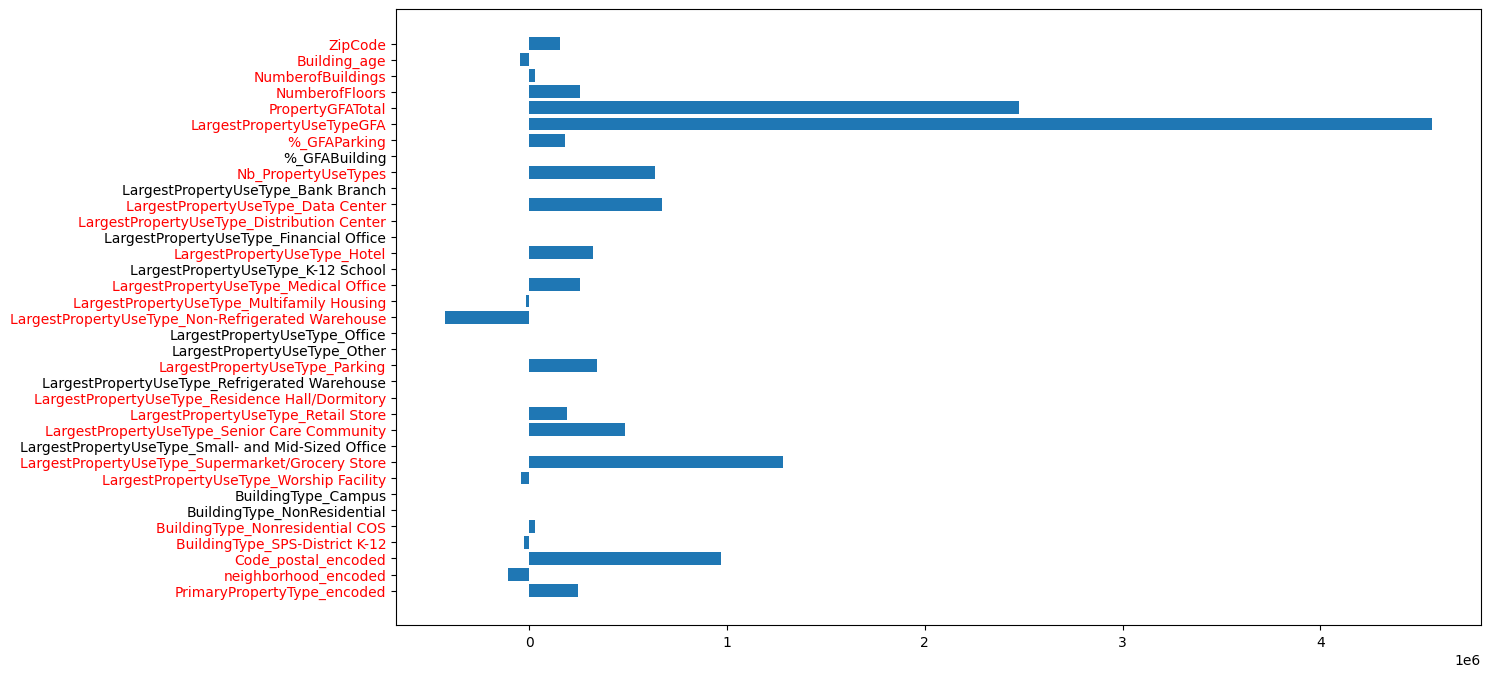

In [56]:
show_fetures_coef(grid_lasso_ghe, columns_ghe)

### vérification du scaling des données

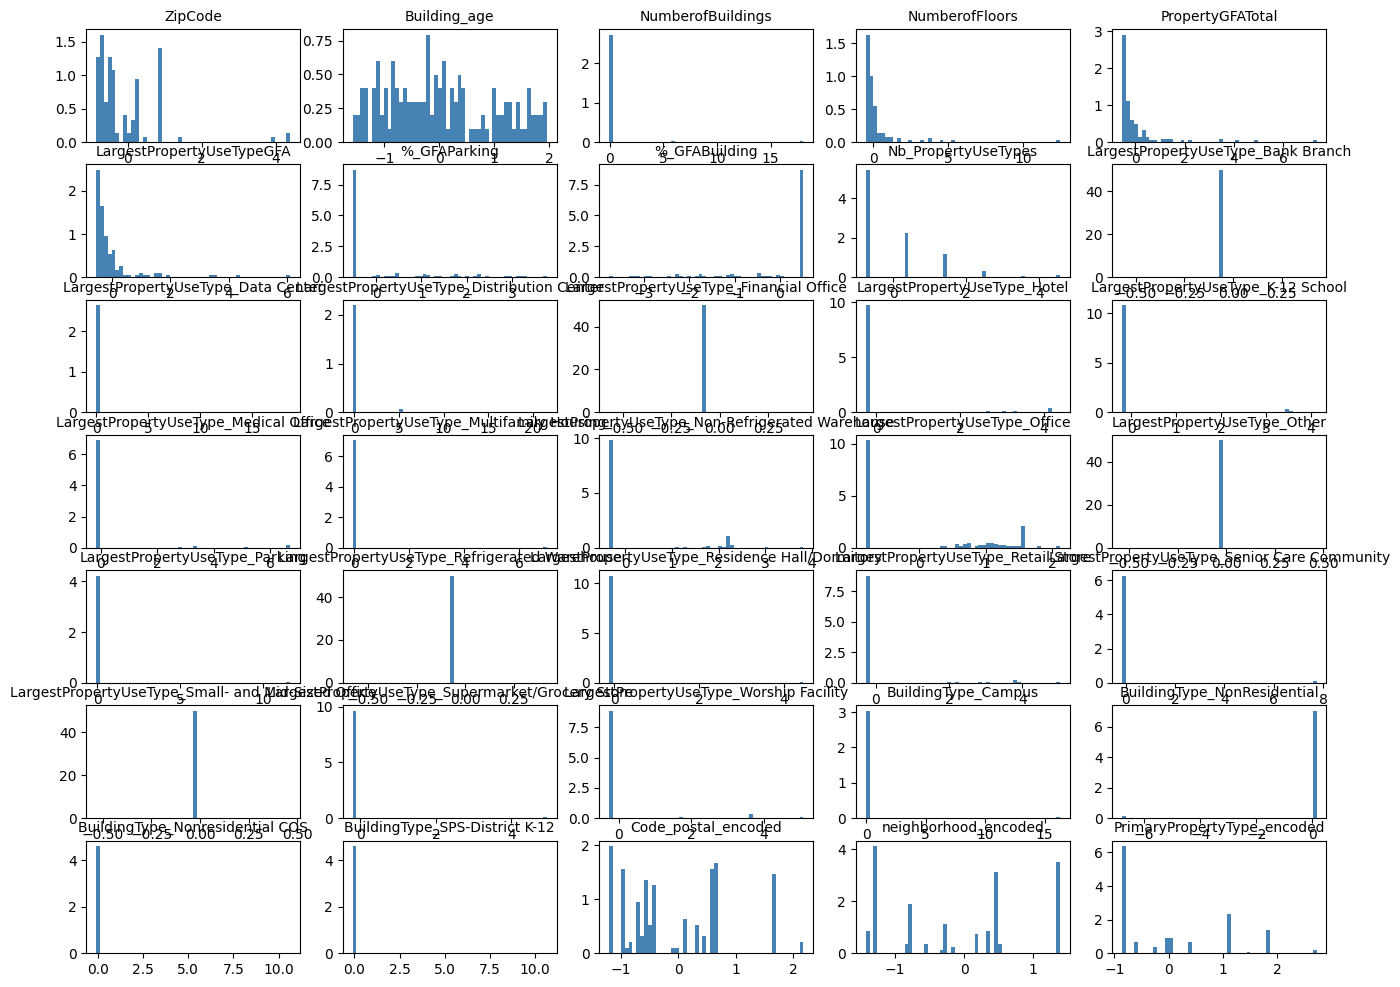

In [57]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X_enrg_test.shape[1]):
    ax = fig.add_subplot(7,5, (feat_idx+1))
    h = ax.hist(X_enrg_test[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(columns_enrg[feat_idx], fontsize=10)

### Ridge 

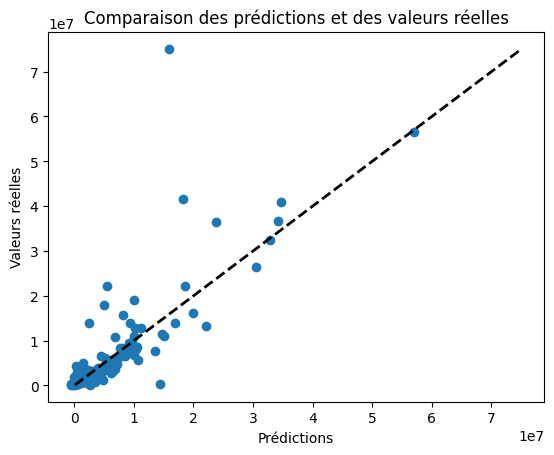

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.148406,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,DecisionTreeRegressor(max_depth=5),0.2602,68.8081,12546.9954,0.007581,"{'max_depth': 5, 'min_samples_leaf': 1}"
6,TotalGHGEmissions,(DecisionTreeRegressor(criterion='absolute_err...,0.6017,54.9597,6755.7271,0.994573,"{'criterion': 'absolute_error', 'max_features'..."
7,TotalGHGEmissions,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.4637,60.8042,9095.3301,6.415867,"{'eta': 0.01, 'max_features': 0.3, 'n_estimato..."
8,TotalGHGEmissions,"LGBMRegressor(learning_rate=0.01, n_estimators...",0.4331,62.5931,9615.3190,2.012598,"{'learning_rate': 0.01, 'n_estimators': 1000}"
9,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004550,{'strategy': 'mean'}


In [58]:
ridge = Ridge(random_state=42)
alpha_space = np.logspace(-5, 3, 15)   # Checking for alpha from .0001 to 1 and finding the best value for alpha
parameters = {"alpha" : alpha_space}
grid_ridge_ghe = GridSearchCV(ridge, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_ridge_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df, grid_ridge_ghe)

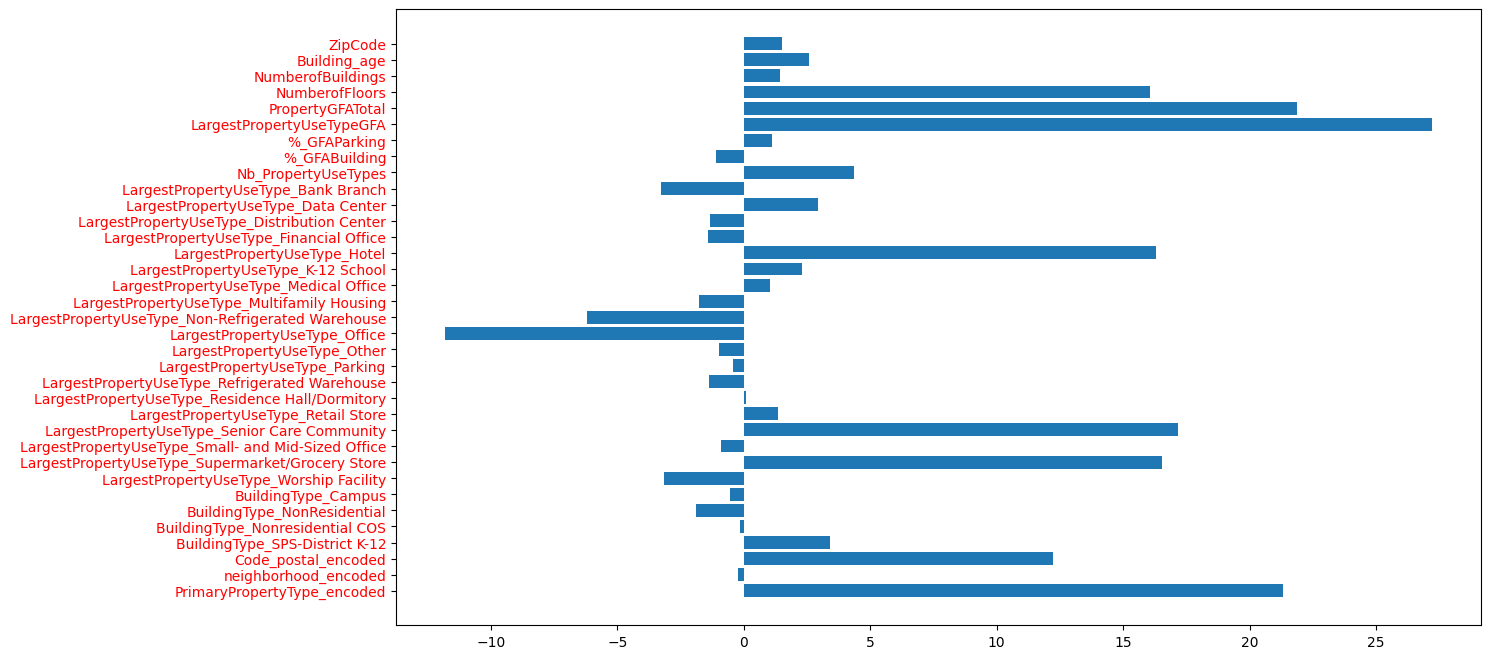

In [59]:
show_fetures_coef(grid_ridge_nrg, columns_enrg)

### Elastic Net

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.067e+15, tolerance: 5.490e+12
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.725e+15, tolerance: 5.710e+12
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

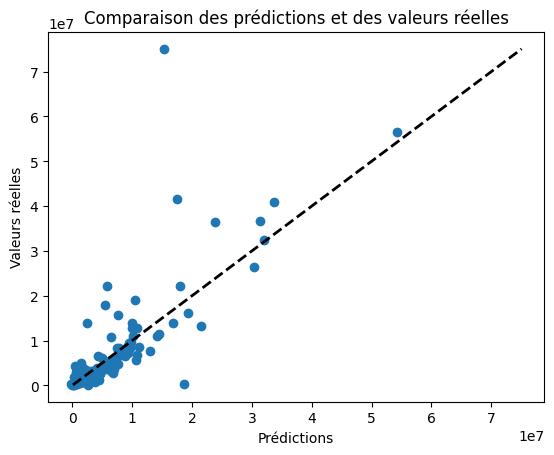

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.148406,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,DecisionTreeRegressor(max_depth=5),0.2602,68.8081,12546.9954,0.007581,"{'max_depth': 5, 'min_samples_leaf': 1}"
6,TotalGHGEmissions,(DecisionTreeRegressor(criterion='absolute_err...,0.6017,54.9597,6755.7271,0.994573,"{'criterion': 'absolute_error', 'max_features'..."
7,TotalGHGEmissions,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.4637,60.8042,9095.3301,6.415867,"{'eta': 0.01, 'max_features': 0.3, 'n_estimato..."
8,TotalGHGEmissions,"LGBMRegressor(learning_rate=0.01, n_estimators...",0.4331,62.5931,9615.3190,2.012598,"{'learning_rate': 0.01, 'n_estimators': 1000}"
9,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004550,{'strategy': 'mean'}


In [60]:
elnet = ElasticNet(max_iter=20000,random_state=42)
alpha_space = np.logspace(-5, 3, 15)   # Checking for alpha from .0001 to 1 and finding the best value for alpha
l1_space = np.logspace(-3, 0, 15)
parameters = {"alpha" : alpha_space,
            "l1_ratio" : l1_space}
grid_elnet_ghe = GridSearchCV(elnet, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_elnet_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df, grid_elnet_ghe)

### Decision tree Regressor

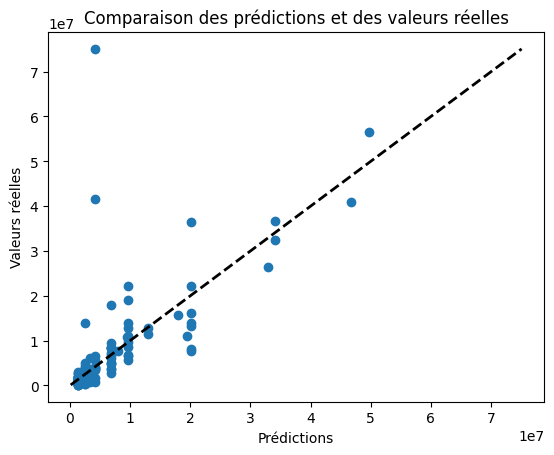

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.148406,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,DecisionTreeRegressor(max_depth=5),0.2602,68.8081,12546.9954,0.007581,"{'max_depth': 5, 'min_samples_leaf': 1}"
6,TotalGHGEmissions,(DecisionTreeRegressor(criterion='absolute_err...,0.6017,54.9597,6755.7271,0.994573,"{'criterion': 'absolute_error', 'max_features'..."
7,TotalGHGEmissions,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.4637,60.8042,9095.3301,6.415867,"{'eta': 0.01, 'max_features': 0.3, 'n_estimato..."
8,TotalGHGEmissions,"LGBMRegressor(learning_rate=0.01, n_estimators...",0.4331,62.5931,9615.3190,2.012598,"{'learning_rate': 0.01, 'n_estimators': 1000}"
9,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004550,{'strategy': 'mean'}


In [61]:
dectree = DecisionTreeRegressor(random_state=42)
parameters = {'min_samples_leaf': [1, 2, 3,4,5],
            'max_depth': range(5,10)}

grid_dectree_ghe = GridSearchCV(dectree, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_dectree_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df, grid_dectree_ghe)

### RandomForest

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/cyrielle/.pyenv

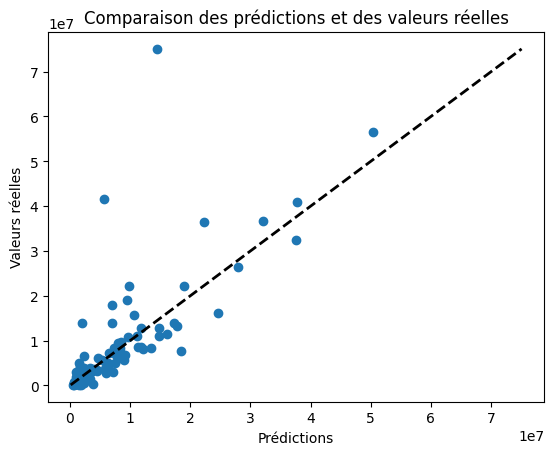

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.148406,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,DecisionTreeRegressor(max_depth=5),0.2602,68.8081,12546.9954,0.007581,"{'max_depth': 5, 'min_samples_leaf': 1}"
6,TotalGHGEmissions,(DecisionTreeRegressor(criterion='absolute_err...,0.6017,54.9597,6755.7271,0.994573,"{'criterion': 'absolute_error', 'max_features'..."
7,TotalGHGEmissions,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.4637,60.8042,9095.3301,6.415867,"{'eta': 0.01, 'max_features': 0.3, 'n_estimato..."
8,TotalGHGEmissions,"LGBMRegressor(learning_rate=0.01, n_estimators...",0.4331,62.5931,9615.3190,2.012598,"{'learning_rate': 0.01, 'n_estimators': 1000}"
9,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004550,{'strategy': 'mean'}


In [62]:
randomforest = RandomForestRegressor(random_state=42)
parameters = {'min_samples_leaf': [1, 2, 3],
            'criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
            'max_features': [0.3,0.5,0.75,1,"sqrt","log2"]}

grid_randomforest_ghe = GridSearchCV(randomforest, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_randomforest_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df, grid_randomforest_ghe)

### XGBoost

[21:48:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:48:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:48:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:48:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:48:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:48:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/

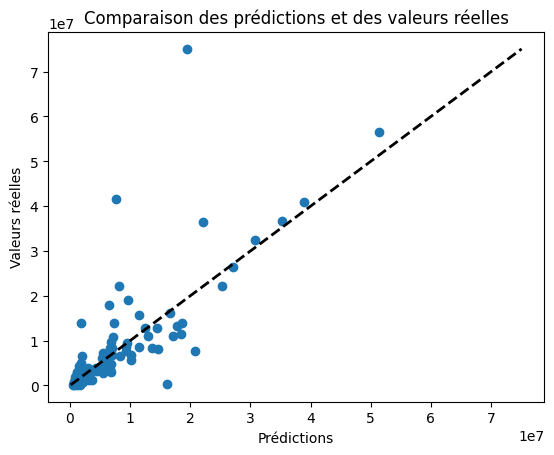

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.148406,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,DecisionTreeRegressor(max_depth=5),0.2602,68.8081,12546.9954,0.007581,"{'max_depth': 5, 'min_samples_leaf': 1}"
6,TotalGHGEmissions,(DecisionTreeRegressor(criterion='absolute_err...,0.6017,54.9597,6755.7271,0.994573,"{'criterion': 'absolute_error', 'max_features'..."
7,TotalGHGEmissions,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.4637,60.8042,9095.3301,6.415867,"{'eta': 0.01, 'max_features': 0.3, 'n_estimato..."
8,TotalGHGEmissions,"LGBMRegressor(learning_rate=0.01, n_estimators...",0.4331,62.5931,9615.3190,2.012598,"{'learning_rate': 0.01, 'n_estimators': 1000}"
9,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004550,{'strategy': 'mean'}


In [63]:
parameters = {'n_estimators': range(1000,1500,100),
            'eta': [0.01,0.001,0.03,0.1,0.3],
            'max_features': [0.3,0.5,0.75,1,"sqrt","log2"]}

grid_xgboost_ghe = GridSearchCV(xgboost, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_xgboost_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df, grid_xgboost_ghe)

### LightBoost

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/v

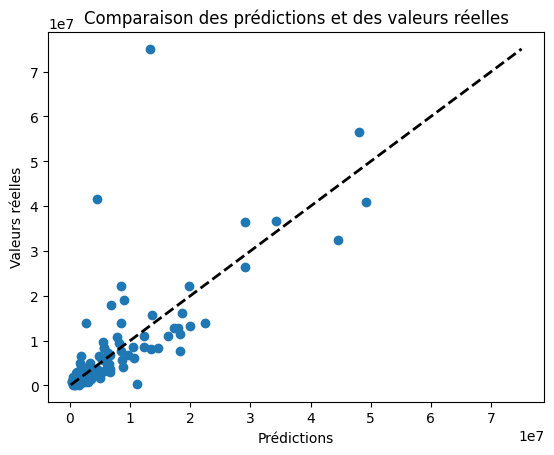

,label,modèle,r2,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,DummyRegressor(quantile=0.25),-0.0000,96.1383,16960.8536,0.007888,"{'quantile': 0.25, 'strategy': 'mean'}"
1,TotalGHGEmissions,LinearRegression(fit_intercept=False),-0.1930,112.3461,20234.0530,0.010651,{'fit_intercept': False}
2,TotalGHGEmissions,Lasso(alpha=5.1794746792312125),0.4983,62.1181,8509.2724,0.014613,{'alpha': 5.1794746792312125}
3,TotalGHGEmissions,Ridge(alpha=268.26957952797216),0.4899,63.2777,8651.4328,0.006863,{'alpha': 268.26957952797216}
4,TotalGHGEmissions,"ElasticNet(alpha=1.389495494373136, l1_ratio=0...",0.4849,63.4031,8736.8212,0.148406,"{'alpha': 1.389495494373136, 'l1_ratio': 0.610..."
5,TotalGHGEmissions,DecisionTreeRegressor(max_depth=5),0.2602,68.8081,12546.9954,0.007581,"{'max_depth': 5, 'min_samples_leaf': 1}"
6,TotalGHGEmissions,(DecisionTreeRegressor(criterion='absolute_err...,0.6017,54.9597,6755.7271,0.994573,"{'criterion': 'absolute_error', 'max_features'..."
7,TotalGHGEmissions,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.4637,60.8042,9095.3301,6.415867,"{'eta': 0.01, 'max_features': 0.3, 'n_estimato..."
8,TotalGHGEmissions,"LGBMRegressor(learning_rate=0.01, n_estimators...",0.4331,62.5931,9615.3190,2.012598,"{'learning_rate': 0.01, 'n_estimators': 1000}"
9,SiteEnergyUse(kBtu),DummyRegressor(),-0.0010,6170043.8373,113128824873049.2969,0.004550,{'strategy': 'mean'}


In [64]:
lightboost = LGBMRegressor(random_state=42)
parameters = {'n_estimators': range(1000,1500,100),
            'learning_rate': [0.01,0.001,0.03,0.1,0.3]}

grid_lightboost_ghe = GridSearchCV(lightboost, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_lightboost_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df, grid_lightboost_ghe)